# Predicting Continuous Target Variables with Regression Analysis

##  Exploring the Ames Housing dataset

In [1]:
import pandas as pd
columns = ['Overall Qual', 'Overall Cond', 'Gr Liv Area',
 'Central Air', 'Total Bsmt SF', 'SalePrice']
df = pd.read_csv('http://jse.amstat.org/v19n3/decock/AmesHousing.txt', 
                sep='\t',
                usecols=columns)
df.head()

,Overall Qual,Overall Cond,Total Bsmt SF,Central Air,Gr Liv Area,SalePrice
0,6,5,1080.0,Y,1656,215000
1,5,6,882.0,Y,896,105000
2,6,6,1329.0,Y,1329,172000
3,7,5,2110.0,Y,2110,244000
4,5,5,928.0,Y,1629,189900


In [2]:
df.shape

(2930, 6)

In [3]:
df['Central Air'] = df['Central Air'].map({'N': 0, 'Y': 1})

In [4]:
df.isnull().sum()

Overall Qual     0
Overall Cond     0
Total Bsmt SF    1
Central Air      0
Gr Liv Area      0
SalePrice        0
dtype: int64

In [5]:
df = df.dropna(axis=0)
df.isnull().sum()

Overall Qual     0
Overall Cond     0
Total Bsmt SF    0
Central Air      0
Gr Liv Area      0
SalePrice        0
dtype: int64

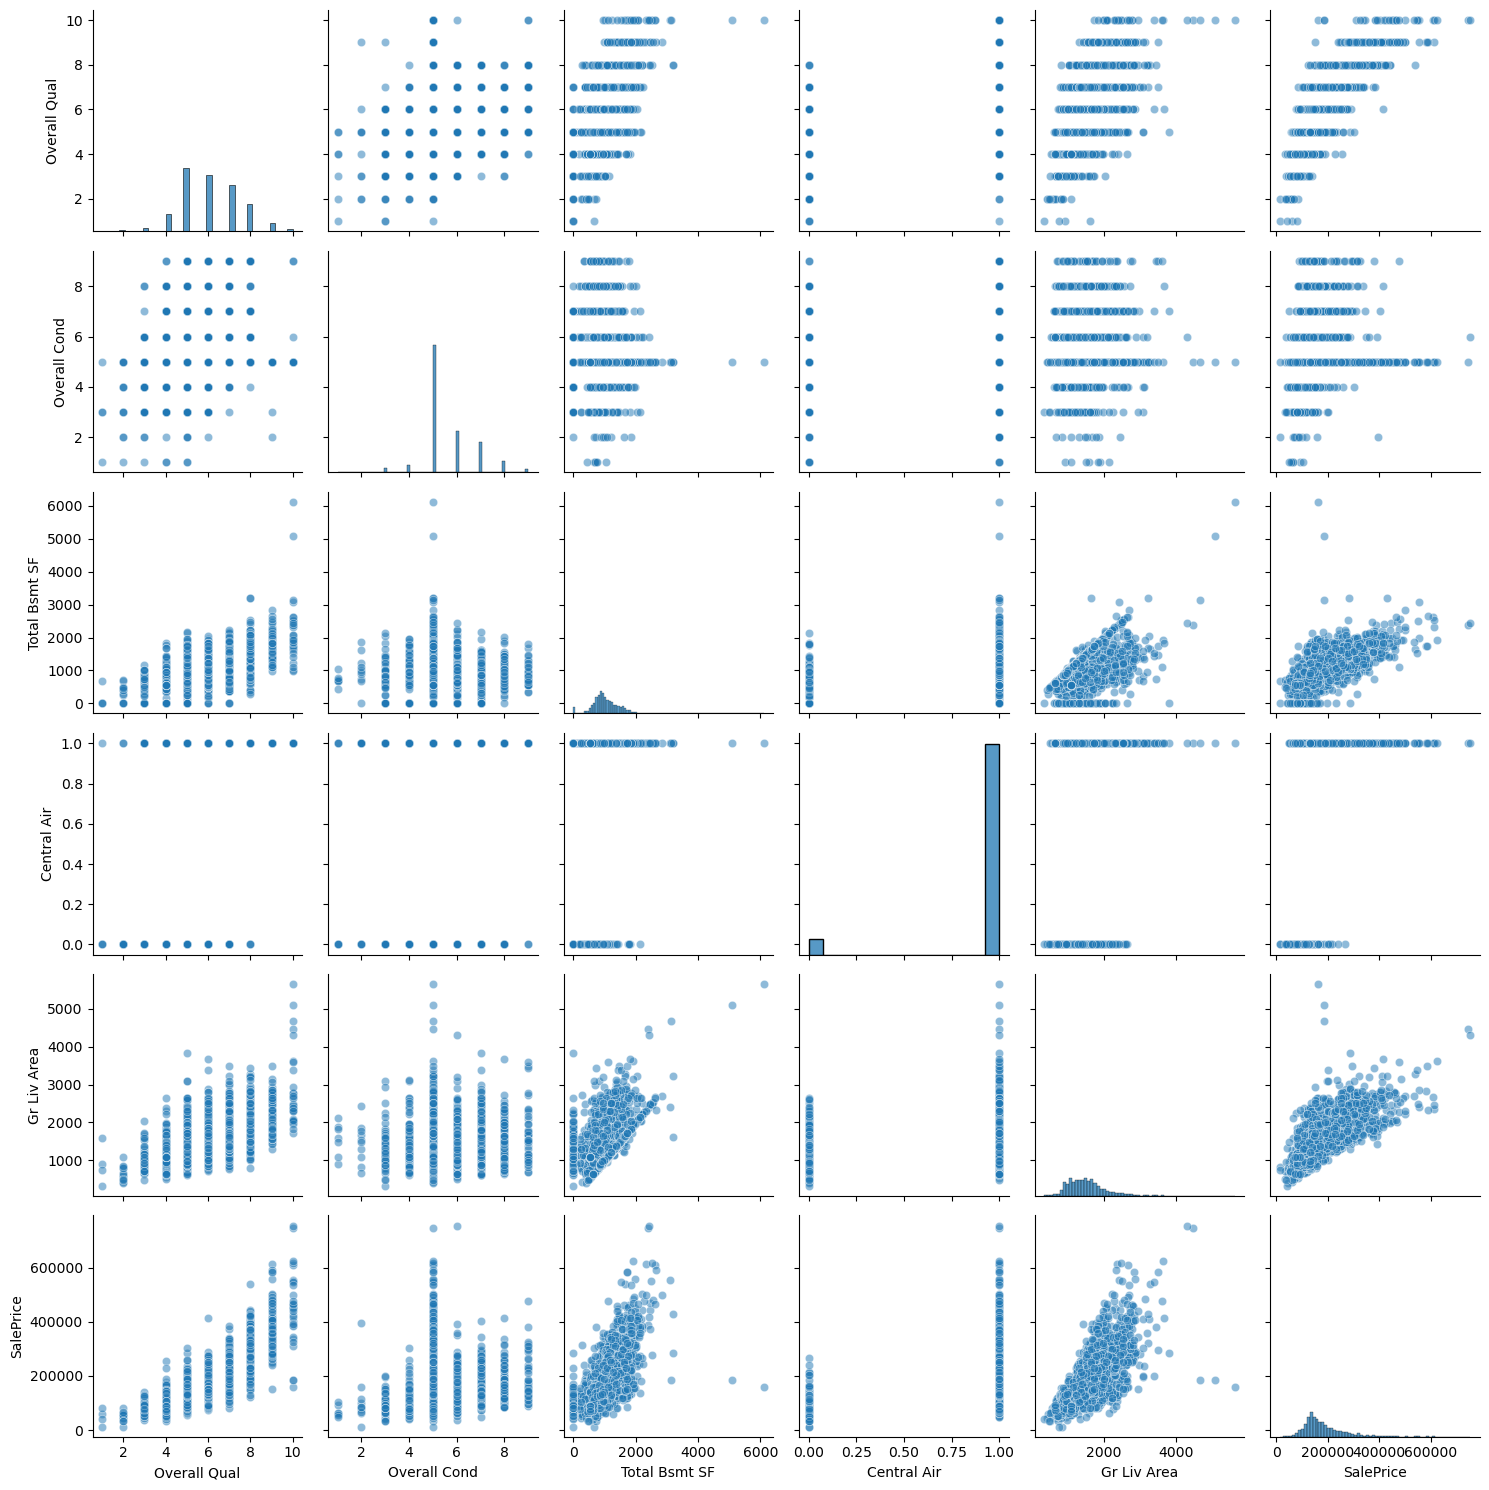

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(df, plot_kws={'alpha': 0.5})  
plt.tight_layout()
plt.show()

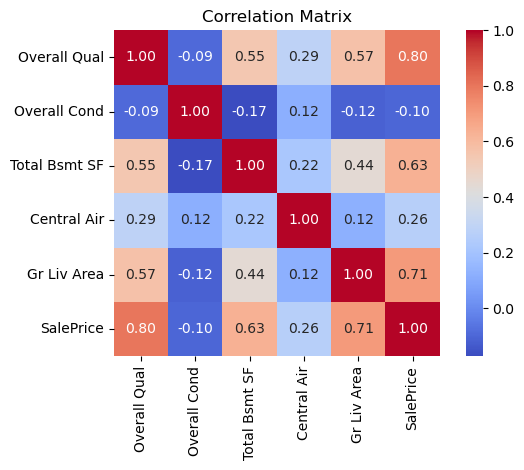

In [10]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
cm = np.corrcoef(df.values.T)  # same as df.corr() for numeric columns

# Plot heatmap using seaborn
sns.heatmap(cm,
            xticklabels=df.columns,
            yticklabels=df.columns,
            cmap='coolwarm',
            annot=True,   # show correlation values
            fmt=".2f",    # format of annotation
            square=True,  # make cells square
            cbar=True)

plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()


##  Solving regression for regression parameters with gradient  descent

In [11]:
class LinearRegressionGD:
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        self.b_ = np.array([0.])
        self.losses_ = []
        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (y - output)
            self.w_ += self.eta * 2.0 * X.T.dot(errors) / X.shape[0]
            self.b_ += self.eta * 2.0 * errors.mean()
            loss = (errors**2).mean()
            self.losses_.append(loss)
        return self
    def net_input(self, X):
        return np.dot(X, self.w_) + self.b_
    def predict(self, X):
        return self.net_input(X)

In [12]:
X = df[['Gr Liv Area']].values
y = df['SalePrice'].values
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten()
lr = LinearRegressionGD(eta=0.1)
lr.fit(X_std, y_std)

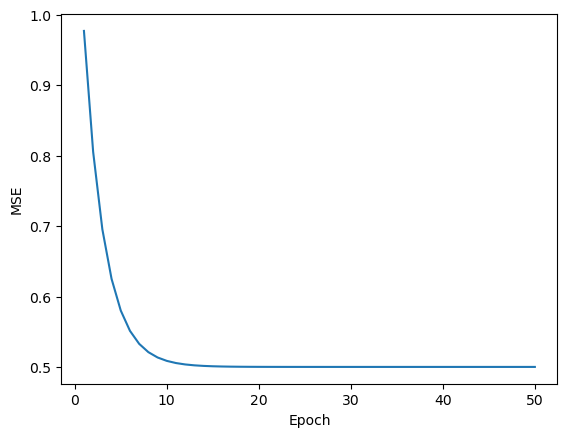

In [13]:
plt.plot(range(1, lr.n_iter+1), lr.losses_)
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.show()

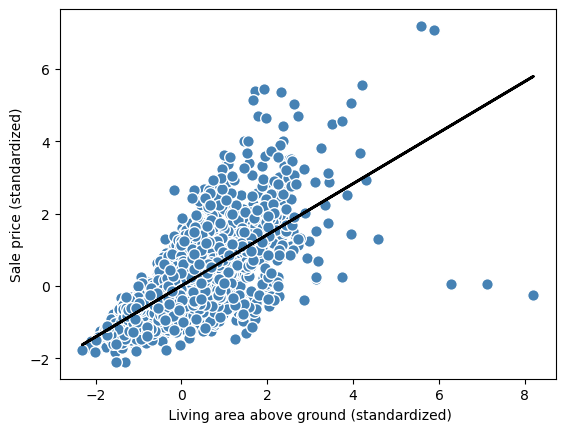

In [15]:
def lin_regplot(X, y, model):
    plt.scatter(X, y, c='steelblue', edgecolor='white', s=70)
    plt.plot(X, model.predict(X), color='black', lw=2)
    
lin_regplot(X_std, y_std, lr)
plt.xlabel(' Living area above ground (standardized)')
plt.ylabel('Sale price (standardized)')
plt.show()

In [16]:
feature_std = sc_x.transform(np.array([[2500]]))
target_std = lr.predict(feature_std)
target_reverted = sc_y.inverse_transform(target_std.reshape(-1, 1))
print(f'Sales price: ${target_reverted.flatten()[0]:.2f}')

Sales price: $292507.07


In [17]:
print(f'Slope: {lr.w_[0]:.3f}')
print(f'Intercept: {lr.b_[0]:.3f}')

Slope: 0.707
Intercept: -0.000


## Estimating the coefficient of a regression model via scikit-learn

Slope: 111.666
Intercept: 13342.979


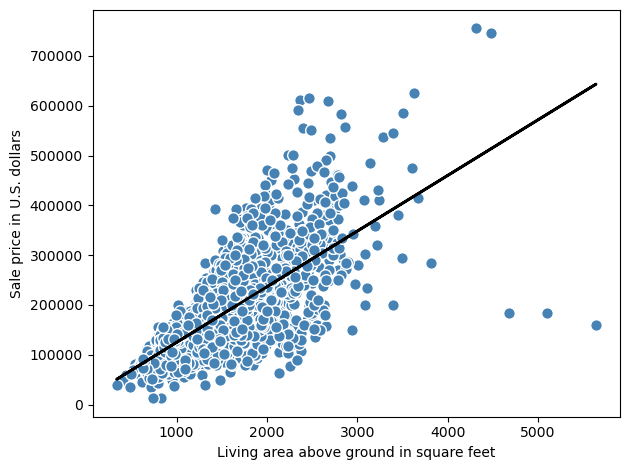

In [18]:
from sklearn.linear_model import LinearRegression
slr = LinearRegression()
slr.fit(X, y)
y_pred = slr.predict(X)
print(f'Slope: {slr.coef_[0]:.3f}')
print(f'Intercept: {slr.intercept_:.3f}')
lin_regplot(X, y, slr)
plt.xlabel('Living area above ground in square feet')
plt.ylabel('Sale price in U.S. dollars')
plt.tight_layout()
plt.show()


 ## Fitting a robust regression model using RANSAC

In [19]:
from sklearn.linear_model import RANSACRegressor
ransac = RANSACRegressor(
                        LinearRegression(), 
                        max_trials=100, # default value
                        min_samples=0.95, 
                        residual_threshold=None, # default value 
                        random_state=123)
ransac.fit(X, y)

,estimator,LinearRegression()
,min_samples,0.95
,residual_threshold,None
,is_data_valid,None
,is_model_valid,None
,max_trials,100
,max_skips,inf
,stop_n_inliers,inf
,stop_score,inf
,stop_probability,0.99
,loss,'absolute_error'


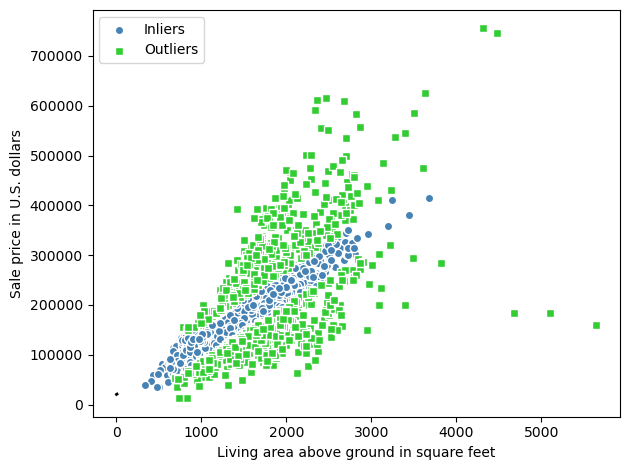

In [20]:
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])
plt.scatter(X[inlier_mask], y[inlier_mask],
            c='steelblue', edgecolor='white',
            marker='o', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask],
            c='limegreen', edgecolor='white',
            marker='s', label='Outliers')
plt.plot(line_X, line_y_ransac, color='black', lw=2)
plt.xlabel('Living area above ground in square feet')
plt.ylabel('Sale price in U.S. dollars')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


In [21]:
print(f'Slope: {ransac.estimator_.coef_[0]:.3f}')
print(f'Intercept: {ransac.estimator_.intercept_:.3f}')

Slope: 106.348
Intercept: 20190.093


# Evaluating the performance of linear regression models

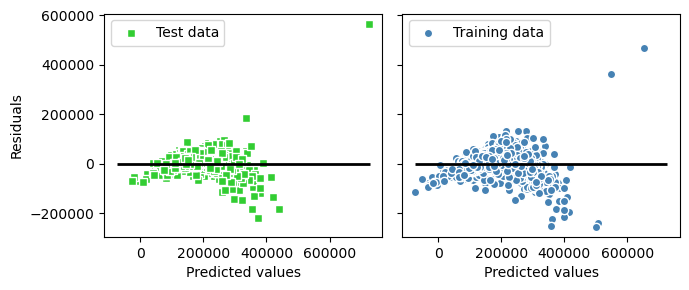

In [22]:
from sklearn.model_selection import train_test_split
target = 'SalePrice'
features = df.columns[df.columns != target]
X = df[features].values
y = df[target].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123) 
slr = LinearRegression()
slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)


x_max = np.max([np.max(y_train_pred), np.max(y_test_pred)])
x_min = np.min([np.min(y_train_pred), np.min(y_test_pred)])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3), sharey=True)
ax1.scatter(y_test_pred, y_test_pred - y_test,
            c='limegreen', marker='s',
            edgecolor='white',
            label='Test data')
ax2.scatter( y_train_pred, y_train_pred - y_train,
            c='steelblue', marker='o', edgecolor='white',
            label='Training data')
ax1.set_ylabel('Residuals')
for ax in (ax1, ax2):
    ax.set_xlabel('Predicted values')
    ax.legend(loc='upper left')
    ax.hlines(y=0, xmin=x_min-100, xmax=x_max+100, color='black', lw=2)
plt.tight_layout()
plt.show() 


In [23]:
from sklearn.metrics import mean_squared_error
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print(f'MSE test: {mse_test:.2f}')
print(f'MSE train: {mse_train:.2f}')

MSE test: 1516565821.00
MSE train: 1497216245.85


In [24]:
from sklearn.metrics import mean_absolute_error
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
print(f'MAE train: {mae_train:.2f}')
print(f'MAE test: {mae_test:.2f}')

MAE train: 25983.03
MAE test: 24921.29


In [25]:
from sklearn.metrics import r2_score
train_r2 = r2_score(y_train, y_train_pred) 
test_r2 = r2_score(y_test, y_test_pred)
print(f'R^2 train: {train_r2:.3f}, {test_r2:.3f}')

R^2 train: 0.769, 0.752


# Using regularized methods for regression

In [ ]:

from sklearn.linear_model import Ridge
ridge = Ridge(alpha=1.0)

from sklearn.linear_model import Lasso
lasso = Lasso(alpha=1.0)

from sklearn.linear_model import ElasticNet
elanet = ElasticNet(alpha=1.0, l1_ratio=0.5)

## Turning a linear regression model into a curve –  polynomial regression

In [26]:
from sklearn.preprocessing import PolynomialFeatures
X = np.array([ 258.0, 270.0, 294.0, 320.0, 342.0,
              368.0, 396.0, 446.0, 480.0, 586.0])\
             [:, np.newaxis]
y = np.array([ 236.4, 234.4, 252.8, 298.6, 314.2,
               342.2, 360.8, 368.0, 391.2, 390.8])
lr = LinearRegression()
pr = LinearRegression()
quadratic = PolynomialFeatures(degree=2)
X_quad = quadratic.fit_transform(X)

In [27]:
lr.fit(X, y)
X_fit = np.arange(250, 600, 10)[:, np.newaxis]
y_lin_fit = lr.predict(X_fit)

In [28]:
pr.fit(X_quad, y)
y_quad_fit = pr.predict(quadratic.fit_transform(X_fit))

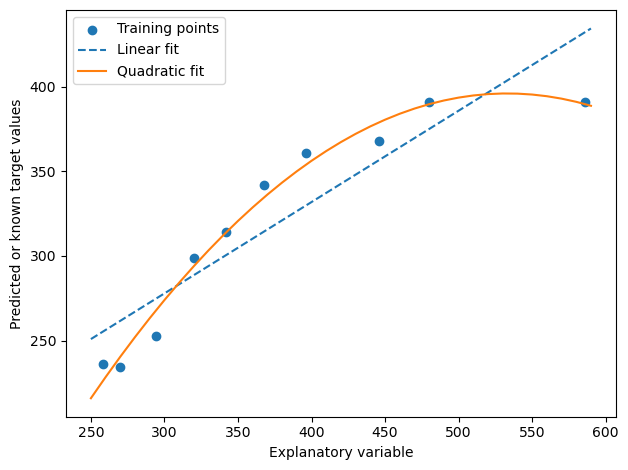

In [29]:
plt.scatter(X, y, label='Training points')
plt.plot(X_fit, y_lin_fit,
         label='Linear fit', linestyle='--')
plt.plot(X_fit, y_quad_fit,
         label='Quadratic fit')
plt.xlabel('Explanatory variable')
plt.ylabel('Predicted or known target values')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


In [30]:
y_lin_pred = lr.predict(X)
y_quad_pred = pr.predict(X_quad)
mse_lin = mean_squared_error(y, y_lin_pred)
mse_quad = mean_squared_error(y, y_quad_pred)
print(f'Training MSE linear: {mse_lin:.3f}'
      f', quadratic: {mse_quad:.3f}')

r2_lin = r2_score(y, y_lin_pred)
r2_quad = r2_score(y, y_quad_pred)
print(f'Training R^2 linear: {r2_lin:.3f}'
       f', quadratic: {r2_quad:.3f}')

Training MSE linear: 569.780, quadratic: 61.330
Training R^2 linear: 0.832, quadratic: 0.982


## Modeling nonlinear relationships in the Ames Housing dataset

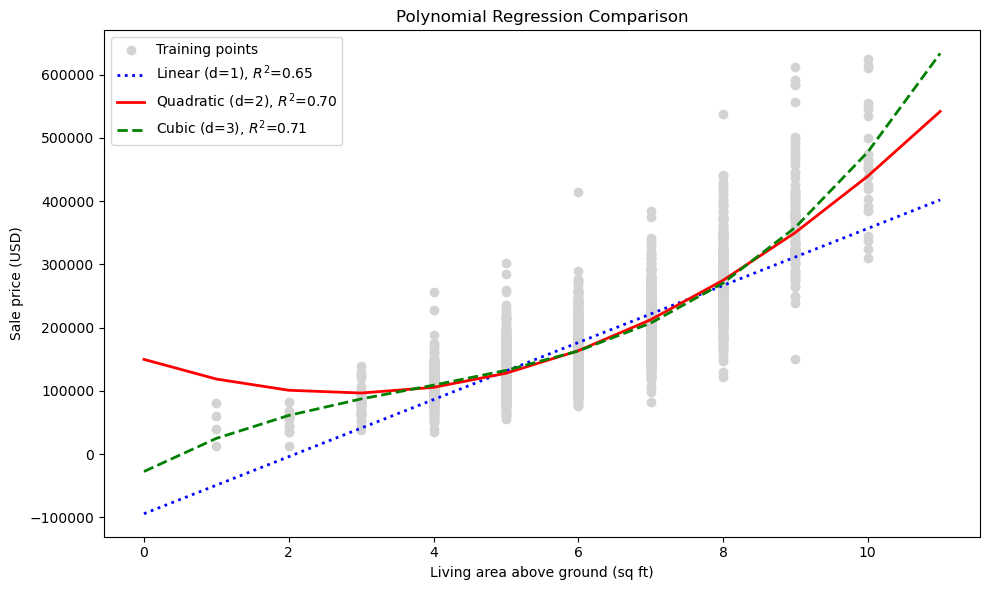

In [32]:
# Select features and target
X = df[['Overall Qual']].values
y = df['SalePrice'].values

# Filter out outliers
mask = df['Gr Liv Area'] < 4000
X = X[mask]
y = y[mask]

# Prepare polynomial transformers
quadratic = PolynomialFeatures(degree=2)
cubic = PolynomialFeatures(degree=3)

X_quad = quadratic.fit_transform(X)
X_cubic = cubic.fit_transform(X)

# Fit linear model
regr = LinearRegression()
X_fit = np.arange(X.min() - 1, X.max() + 2, 1)[:, np.newaxis]

# Linear fit
regr.fit(X, y)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y, regr.predict(X))

# Quadratic fit
regr.fit(X_quad, y)
y_quad_fit = regr.predict(quadratic.transform(X_fit))
quadratic_r2 = r2_score(y, regr.predict(X_quad))

# Cubic fit
regr.fit(X_cubic, y)
y_cubic_fit = regr.predict(cubic.transform(X_fit))
cubic_r2 = r2_score(y, regr.predict(X_cubic))

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(X, y, label='Training points', color='lightgray')

plt.plot(X_fit, y_lin_fit, label=f'Linear (d=1), $R^2$={linear_r2:.2f}',
         color='blue', lw=2, linestyle=':')

plt.plot(X_fit, y_quad_fit, label=f'Quadratic (d=2), $R^2$={quadratic_r2:.2f}',
         color='red', lw=2, linestyle='-')

plt.plot(X_fit, y_cubic_fit, label=f'Cubic (d=3), $R^2$={cubic_r2:.2f}',
         color='green', lw=2, linestyle='--')

plt.xlabel('Living area above ground (sq ft)')
plt.ylabel('Sale price (USD)')
plt.legend(loc='upper left')
plt.title('Polynomial Regression Comparison')
plt.tight_layout()
plt.show()

# Dealing with nonlinear relationships using random  forests

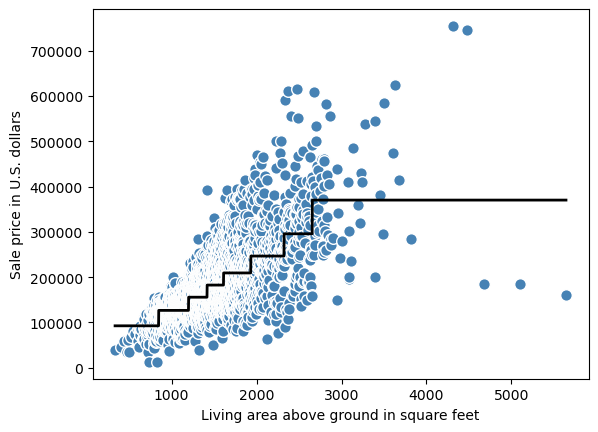

In [34]:
from sklearn.tree import DecisionTreeRegressor
X = df[['Gr Liv Area']].values
y = df['SalePrice'].values
tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X, y)
sort_idx = X.flatten().argsort()
lin_regplot(X[sort_idx], y[sort_idx], tree)
plt.xlabel('Living area above ground in square feet')
plt.ylabel('Sale price in U.S. dollars')
plt.show()

In [36]:
# Define target and features
target = 'SalePrice'
features = df.columns[df.columns != target]

X = df[features].values
y = df[target].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=123
)

from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(
    n_estimators=1000,
    criterion='squared_error',
    random_state=1,
    n_jobs=-1
)

# Train model
forest.fit(X_train, y_train)

# Predict
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

# Evaluate
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# Results
print(f'MAE (Train): {mae_train:.2f}')
print(f'MAE (Test): {mae_test:.2f}')
print(f'R^2 (Train): {r2_train:.2f}')
print(f'R^2 (Test): {r2_test:.2f}')

MAE (Train): 8305.18
MAE (Test): 20821.77
R^2 (Train): 0.98
R^2 (Test): 0.85


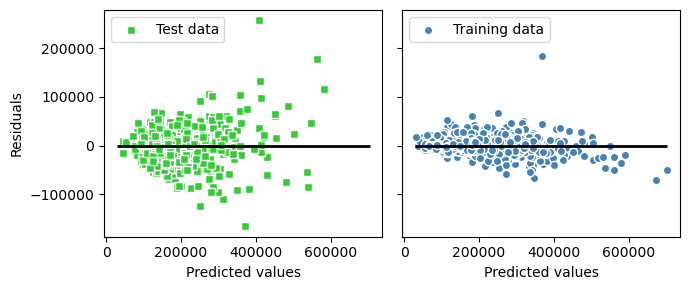

In [37]:
# Calculate axis limits
x_max = np.max([np.max(y_train_pred), np.max(y_test_pred)])
x_min = np.min([np.min(y_train_pred), np.min(y_test_pred)])

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3), sharey=True)

# Test residuals
ax1.scatter(
    y_test_pred,
    y_test_pred - y_test,
    c='limegreen',
    marker='s',
    edgecolor='white',
    label='Test data'
)

# Train residuals
ax2.scatter(
    y_train_pred,
    y_train_pred - y_train,
    c='steelblue',
    marker='o',
    edgecolor='white',
    label='Training data'
)

# Labels
ax1.set_ylabel('Residuals')
for ax in (ax1, ax2):
    ax.set_xlabel('Predicted values')
    ax.legend(loc='upper left')
    ax.hlines(y=0, xmin=x_min - 100, xmax=x_max + 100, color='black', lw=2)

# Final plot layout
plt.tight_layout()
plt.show()
